In [1]:
import sys
import joblib
import numpy as np
import matplotlib as mpl
from sklearn.metrics import roc_auc_score
from scipy.io import savemat
np.set_printoptions(precision=2)

mpl.rc("savefig", dpi=600)

from matplotlib import pyplot as plt
import matplotlib.patches as patches

sys.path.append('../..')
%matplotlib inline

In [12]:
res = joblib.load('../saved_data/discrete_results.pkl')
res2 = joblib.load('../saved_data/discrete_nnresults.pkl')
res.update(res2)
res.keys()

['rcit_discrete_600mt_10000samples_8dim_32complexity',
 'cci_discrete_600mt_1000samples_8dim_8complexity',
 'kcit_discrete_600mt_100000samples_32dim_2complexity',
 'rcit_discrete_600mt_100000samples_8dim_8complexity',
 'rcit_discrete_600mt_1000samples_8dim_8complexity',
 'kcit_discrete_600mt_10000samples_8dim_2complexity',
 'cci_discrete_600mt_400samples_32dim_8complexity',
 'kcit_discrete_600mt_100000samples_2dim_2complexity',
 'chsic_discrete_600mt_400samples_2dim_8complexity',
 'rcit_discrete_600mt_200samples_32dim_8complexity',
 'nn_discrete_600mt_400samples_2dim_32complexity',
 'chsic_discrete_600mt_1000samples_32dim_2complexity',
 'chsic_discrete_600mt_1000samples_32dim_8complexity',
 'cci_discrete_600mt_400samples_32dim_32complexity',
 'kcipt_discrete_600mt_10000samples_2dim_8complexity',
 'nn_discrete_600mt_10000samples_32dim_32complexity',
 'kcit_discrete_600mt_100000samples_8dim_32complexity',
 'rcit_discrete_600mt_200samples_32dim_2complexity',
 'nn_discrete_600mt_100000samp

In [11]:
""" RUN THIS WITH FULL DATA """
from independence_test.experiment_cond_strength import DSETS, COND_METHODS
from independence_test.utils import pc_ks
SAMPLE_NUMS = [200, 400, 1000, 10000]
DSET_NAME = 'discrete'
RES_FNAME = '../saved_data/{}_results.pkl'.format(DSET_NAME)
#res = joblib.load(RES_FNAME)
res_mats = {}
for key in res.keys():
    pval_d = np.array(res[key])[:, 0]
    pval_i = np.array(res[key])[:, 1]
    time = np.array(res[key])[:, 2]
    #res_mats[key] = (pc_ks(pval_d)[0], pc_ks(pval_i)[1], np.median(pval_i))
    res_mats[key] = ((pval_d < .05).sum()/float(pval_d.size),
                     (pval_i > .05).sum() / float(pval_i.size),
                     (pval_d < .01).sum()/float(pval_d.size),
                     (pval_i > .01).sum()/ float(pval_i.size),
                     pc_ks(pval_d)[0],
                     pc_ks(pval_i)[1],
                     roc_auc_score(np.concatenate([np.zeros(pval_d.size), np.ones(pval_i.size)]), np.concatenate([pval_d, pval_i])),
                     time.mean())
    if (pval_d < 0).sum() + (pval_i < 0).sum() > 0:
        res_mats[key] = (-1, -1, -1, -1, -1, -1, -1, -1)
    
proc_res = {}
GAMMA = DSETS[DSET_NAME][1]
proc_res['row_samplenums'] = SAMPLE_NUMS
proc_res['col_gamma'] = GAMMA
for method in COND_METHODS:
    proc_res[method + '_d05'] = np.zeros((len(SAMPLE_NUMS), len(GAMMA)))
    proc_res[method + '_i05'] = np.zeros((len(SAMPLE_NUMS), len(GAMMA)))
    proc_res[method + '_d01'] = np.zeros((len(SAMPLE_NUMS), len(GAMMA)))
    proc_res[method + '_i01'] = np.zeros((len(SAMPLE_NUMS), len(GAMMA)))
    proc_res[method + '_pcauc'] = np.zeros((len(SAMPLE_NUMS), len(GAMMA)))
    proc_res[method + '_ks'] = np.zeros((len(SAMPLE_NUMS), len(GAMMA)))
    proc_res[method + '_auc'] = np.zeros((len(SAMPLE_NUMS), len(GAMMA)))
    proc_res[method + '_time'] = np.zeros((len(SAMPLE_NUMS), len(GAMMA)))
    for row_id, n_samples in enumerate(SAMPLE_NUMS):
        for col_id, gamma in enumerate(GAMMA):
            res = res_mats[method + '_' + DSET_NAME + '_600mt_' + str(n_samples) + 'samples_1dim_' + str(gamma) + 'complexity']
            proc_res[method + '_d05'][row_id, col_id] = res[0]
            proc_res[method + '_i05'][row_id, col_id] = res[1]
            proc_res[method + '_d01'][row_id, col_id] = res[2]
            proc_res[method + '_i01'][row_id, col_id] = res[3]
            proc_res[method + '_pcauc'][row_id, col_id] = res[4]
            proc_res[method + '_ks'][row_id, col_id] = res[5]
            proc_res[method + '_auc'][row_id, col_id] = res[6]
            proc_res[method + '_time'][row_id, col_id] = res[7]
savemat('../saved_data/{}_results.mat'.format(DSET_NAME), proc_res)

KeyError: 'rcit_discrete_600mt_200samples_1dim_2complexity'

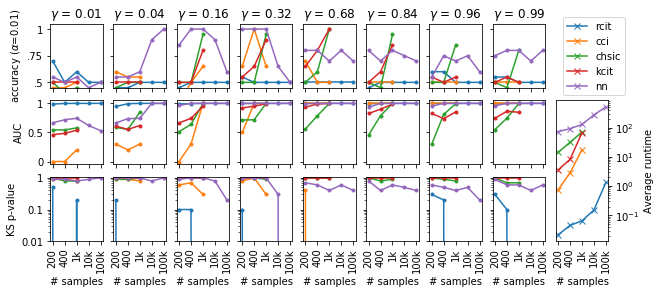

In [188]:
plt.figure(figsize=(10, 4), facecolor='white')
GAMMA = np.sort(GAMMA)
MTDS = ['rcit', 'cci', 'chsic', 'kcit', 'nn']
yticks = [0, .5, 1]
for gamma_id, gamma in enumerate(GAMMA):
    ax = plt.subplot2grid((3, len(GAMMA)+1), (0, gamma_id))
    plt.title(r'$\gamma$ = {:.2g}'.format(gamma))
    for method in MTDS:
        time = proc_res[method + '_time'][:, gamma_id].flatten()
        goodness = (proc_res[method + '_d01'][:, gamma_id].flatten() +
                    proc_res[method + '_i01'][:, gamma_id].flatten()) / 2
        time[time < 0] = np.nan
        goodness[goodness < 0] = np.nan
        ax.plot(goodness.flatten(), '-', label=method, marker='.')
    plt.ylim(.45, 1.05)
    plt.xticks(np.arange(len(SAMPLE_NUMS)), [])

    plt.yticks([.5, .75, 1], [])
    if gamma_id == 0:
        plt.yticks([.5, .75, 1], ['.5', '.75', '1'])
        plt.ylabel(r'accuracy ($\alpha$=0.01)')


    ax = plt.subplot2grid((3, len(GAMMA)+1), (1, gamma_id))
    for method in MTDS:
        time = proc_res[method + '_time'][:, gamma_id].flatten()
        goodness = (proc_res[method + '_pcauc'][:, gamma_id].flatten())
        time[time < 0] = np.nan
        goodness[goodness < 0] = np.nan
        ax.plot(goodness.flatten(), '-', label=method, marker='.')
    plt.yticks(yticks, [])
    plt.xticks(np.arange(len(SAMPLE_NUMS)), [])

    if gamma_id == 0:
        plt.ylabel('AUC')
        plt.yticks(yticks, yticks)
    
    plt.ylim(-.05, 1.05)


    ax = plt.subplot2grid((3, len(GAMMA)+1), (2, gamma_id))
    for method in MTDS:
        time = proc_res[method + '_time'][:, gamma_id].flatten()
        goodness = (proc_res[method + '_i01'][:, gamma_id].flatten())
        time[time < 0] = np.nan
        goodness[goodness < 0] = np.nan
        ax.plot(goodness.flatten(), '-', label=method, marker='.')
    logticks = [.01, .1, 1]
    plt.ylim(.01, 1.05)
    plt.yscale('log')

    if gamma_id > 0:
        plt.yticks(logticks, [])
        plt.xticks(np.arange(len(SAMPLE_NUMS)), [])
    else:
        plt.yticks(logticks, logticks)
        plt.ylabel('KS p-value')
    plt.xlabel('# samples')
    plt.xticks(np.arange(len(SAMPLE_NUMS)), [200, 400, '1k', '10k', '100k'], rotation=90)

        
        
legends = []
ax = plt.subplot2grid((3, len(GAMMA)+1), (1, len(GAMMA)), rowspan=2)
for method in MTDS:
    times = proc_res[method + '_time'].mean(axis=1)
    times[times <= 0] = np.nan
    legends.append(ax.plot(times.flatten(), '-', label=method, marker='x'))
plt.xticks(np.arange(len(SAMPLE_NUMS)))
plt.xlabel('# samples')
plt.xticks(np.arange(len(SAMPLE_NUMS)), [200, 400, '1k', '10k', '100k'], rotation=90)
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')

plt.yscale('log')
plt.ylabel('Average runtime')


plt.legend(bbox_to_anchor=(.05, 1, .1, .1))

AttributeError: 'list' object has no attribute 'get_label'

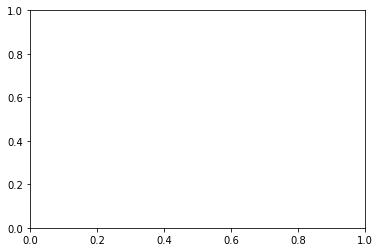

In [164]:
plt.legend(handles=legends[:2])